# Forecasting Inflation

## Getting Data From S3 Bucket

In [1]:
import sagemaker

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
# Get the default Sagemaker session
sagemaker_session = sagemaker.Session()

# Specify the S3 URI where your file is located
s3_uri = 's3://dsci6007-final-project/data/inflation_monthly.csv'

# Download the file from S3
local_path = sagemaker_session.download_data(path='.', bucket=s3_uri.split('/')[2], key_prefix='/'.join(s3_uri.split('/')[3:]))

print("File downloaded to:", local_path)

File downloaded to: ['./inflation_monthly.csv']


## Import Libraries and Load Data

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import datetime
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

np.random.seed(11)
tf.random.set_seed(111)

2024-04-21 03:38:46.073664: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 03:38:46.073706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 03:38:46.074875: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-21 03:38:46.082303: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 03:38:47.146743: W tensorflow/comp

In [4]:
df = pd.read_csv('inflation_monthly.csv', parse_dates=True)

Lets take from 1994 onwards, as there are some NaNs for some of the indicators.

We can do so by simply dropping the NaNs.

In [5]:
df.dropna(inplace=True)
print(df.shape)
df.head()

(334, 12)


,DATE,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
156,1994-01-01,6.6,7.1,3481.800,7363.1,4585.1,105.21,5.750500,3.050645,513314.0,67.0596,154.5
157,1994-02-01,6.6,6.5,3459.675,7377.2,4632.6,104.66,5.973158,3.245000,513196.0,67.1060,154.8
158,1994-03-01,6.5,6.8,3476.975,7401.7,4646.0,104.78,6.482609,3.335806,521040.0,67.7792,155.3
159,1994-04-01,6.4,6.4,3507.150,7402.0,4671.1,104.68,6.972105,3.555000,528063.0,68.1906,155.5
160,1994-05-01,6.1,7.6,3472.840,7487.4,4669.5,103.78,7.183333,4.010968,532328.0,68.5136,155.9


## Data Understanding

Quick check on data types and convert realtime_start and date to datetime.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334 entries, 156 to 489
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    334 non-null    object 
 1   unrate  334 non-null    float64
 2   psr     334 non-null    float64
 3   m2      334 non-null    float64
 4   dspic   334 non-null    float64
 5   pce     334 non-null    float64
 6   reer    334 non-null    float64
 7   ir      334 non-null    float64
 8   ffer    334 non-null    float64
 9   tcs     334 non-null    float64
 10  indpro  334 non-null    float64
 11  ccpi    334 non-null    float64
dtypes: float64(11), object(1)
memory usage: 33.9+ KB


In [7]:
df['DATE'] = pd.to_datetime(df['DATE'])

In [8]:
df.dtypes

DATE      datetime64[ns]
unrate           float64
psr              float64
m2               float64
dspic            float64
pce              float64
reer             float64
ir               float64
ffer             float64
tcs              float64
indpro           float64
ccpi             float64
dtype: object

In [9]:
df_eda = df.copy()

## Exploring Macroeconomic Indicator Trends

We can perform feature generation first and create percentage change Month-over-Month and Year-over-Year.

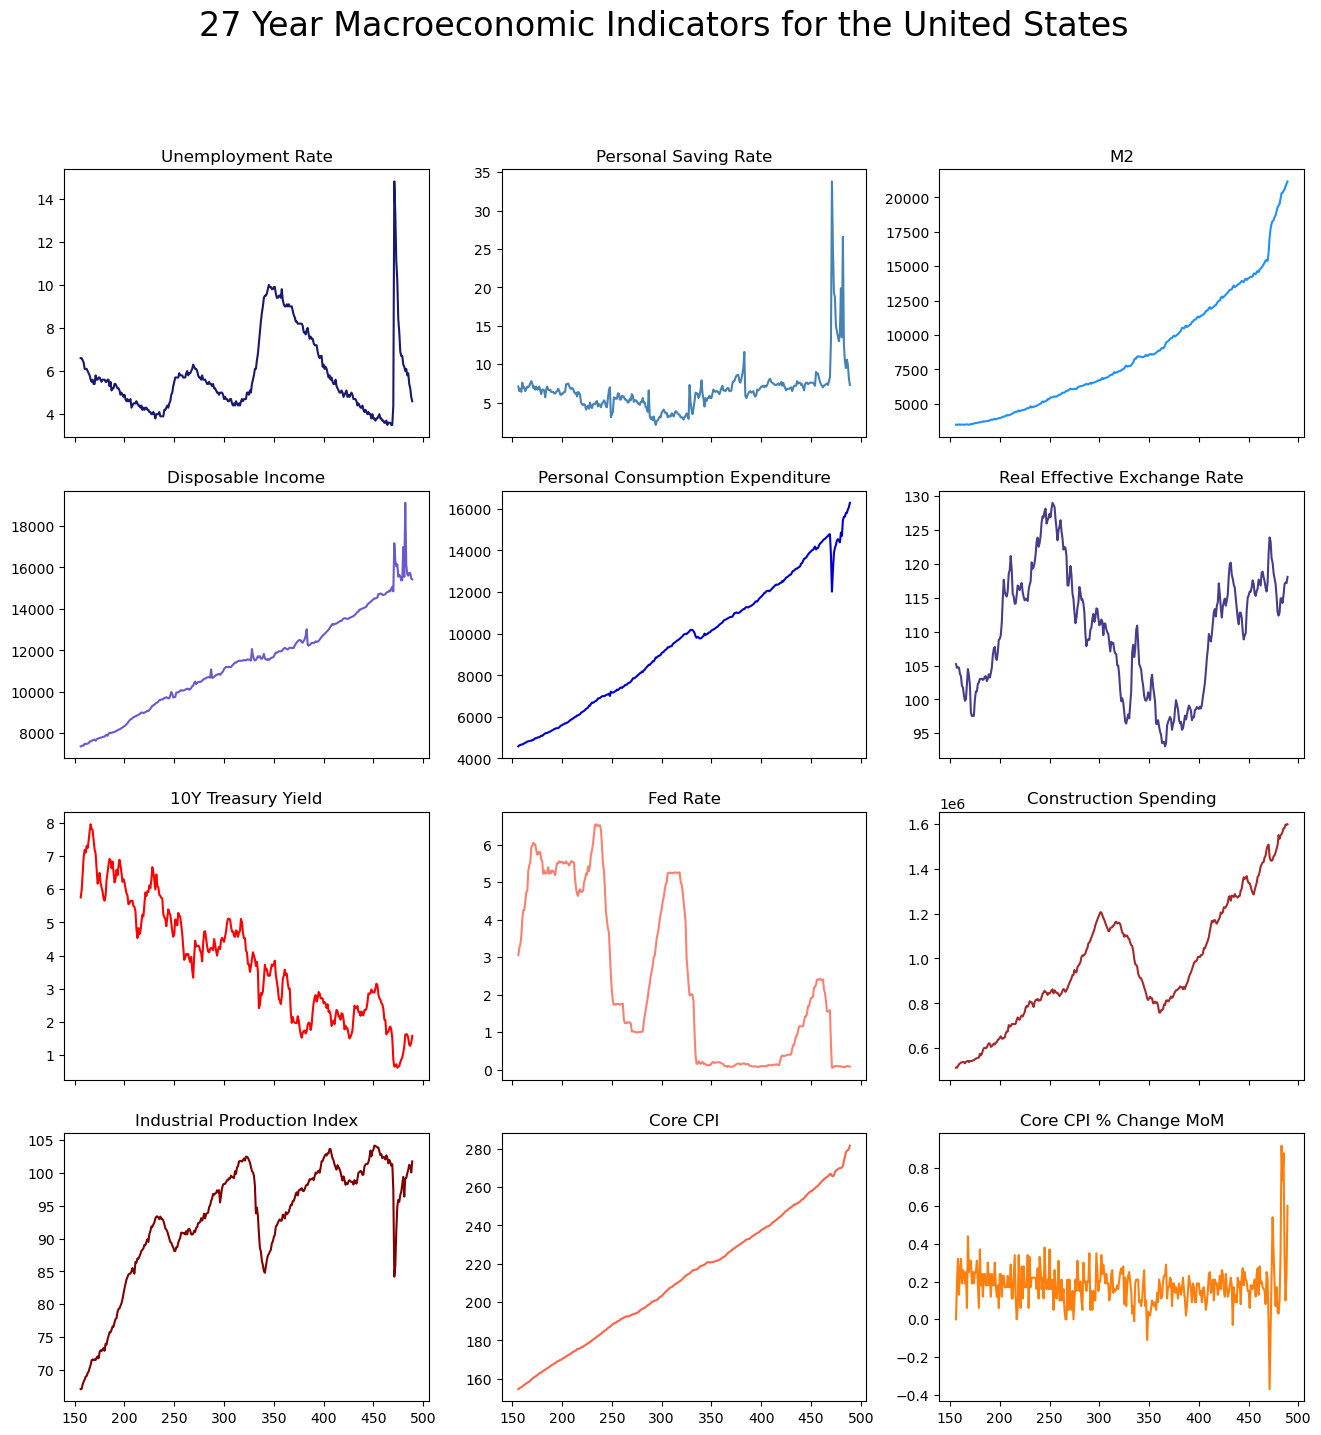

In [10]:
df_eda['cpi_pct_mom'] = round((df_eda['ccpi'].pct_change().fillna(0))*100,2)
df_eda['cpi_pct_yoy'] = round((df_eda['ccpi'].pct_change(12).fillna(0))*100,2)

df_eda.iloc[:, 1:13].plot(kind ='line',
            subplots = True,
            figsize = (16,16),
            title = ['Unemployment Rate', 'Personal Saving Rate','M2','Disposable Income',
                     'Personal Consumption Expenditure','Real Effective Exchange Rate','10Y Treasury Yield',
                     'Fed Rate','Construction Spending','Industrial Production Index','Core CPI','Core CPI % Change MoM'],
            legend = False,
            layout = (4,3),
            sharex = True,
            style = ['midnightblue', 'steelblue', 'dodgerblue', 'slateblue','mediumblue',
                     'darkslateblue','red','salmon','brown','maroon','tomato'])

plt.suptitle('27 Year Macroeconomic Indicators for the United States', fontsize = 24)
plt.show()

## Core CPI Trend by Year, Month, and Quarter

In [11]:
df_eda['year'] = df_eda['DATE'].apply(lambda x: x.year)
df_eda['quarter'] = df_eda['DATE'].apply(lambda x: x.quarter)
df_eda['month'] = df_eda['DATE'].apply(lambda x: x.month)

In [12]:
fig = px.box(df_eda[12:], x="month", y="cpi_pct_yoy", points = "all", template = "presentation")

fig.update_layout(xaxis = dict(tickmode = 'linear'))

fig = px.box(df_eda[12:], x="quarter", y="cpi_pct_yoy", points = "all", template = "presentation")

fig.show()

Looking at the Core CPI change in an annualized basis, we can see that the earlier parts of the year showed more significant increases in Core CPI. While in the last few months, there are more outliers (below the lower whiskers) meaning that they showed little change from the previous year.

We can further explore the volatility of the change in Core CPI YoY.

In [13]:
fig = px.bar(
    data_frame=df_eda.groupby(['month']).std().reset_index(),
    x="month",
    y="cpi_pct_yoy", text="cpi_pct_yoy"
).update_traces(texttemplate='%{text:0.3f}', textposition='outside').update_xaxes(nticks=13)

fig.show()

In [14]:
fig = px.bar(
    data_frame=df_eda.groupby(['quarter']).std().reset_index(),
    x="quarter",
    y="cpi_pct_yoy", text="cpi_pct_yoy"
).update_traces(texttemplate='%{text:0.3f}', textposition='outside').update_xaxes(nticks=5)

fig.show()

## Multivariate Time Series Forecasting with LSTMs

Long Short-Term Memory (LSTM) Recurrent Neural Network are popular in making predictions based on time series data, due to the lags of unknown duration. LSTM addresses that issue of vanishing gradient with multiple switch gates to remember longer time steps. Hence the past inputs to the model leaves a footprint. With LSTMs, there is no need to keep a finite number of states beforehand as required in the Hhidden Markov model. Common limitations (risk) of LSTM is that it is easy to overfit and hard to train in a sense that it takes alot of resources (computing power) to train these models fast, requiring memory-bandwidth-bound computation.

### Data Preparation
- Feature Selection with Granger Causality Test
- Scaling with Min-Max normalization
- Split multivariate sequence into samples with 12 steps in and 1 step out

### Feature Selection

In order to see which features is useful for forecasting core CPI, we will be using the Granger Causality test. One of the key assumptions before using this test requires the data to be stationary. Thus, we would take the first differences for each features and use the same ADF test function to check for stationarity.

In [15]:
df = df.set_index('DATE')

df_stationary = df.diff().dropna()
df_stationary = df_stationary.rename_axis('indicator', axis=1)
fig = px.line(df_stationary.iloc[:,0:10], facet_col="indicator", facet_col_wrap=1) 
fig.update_yaxes(visible=False)

### Augmented Dickey–Fuller Test

With the small p-value, a 1 differencing is enough to remove unit root and make the series stationary.

In [16]:
def adf_test(df):
    result = adfuller(df.values)
    if result[1] > 0.05:
        print("Series is not stationary")
    else:
        print("Series is stationary")

In [17]:
for ind in df_stationary:
    print('ADF Test: ', ind)
    adf_test(df_stationary[[ind]])
    print('')
    
df_stationary[['m2']] = df_stationary[['m2']].diff().dropna()
df_stationary[['tcs']] = df_stationary[['tcs']].diff().dropna()
df_stationary[['ccpi']] = df_stationary[['ccpi']].diff().dropna()

ADF Test:  unrate
Series is stationary

ADF Test:  psr
Series is stationary

ADF Test:  m2
Series is not stationary

ADF Test:  dspic
Series is stationary

ADF Test:  pce
Series is stationary

ADF Test:  reer
Series is stationary

ADF Test:  ir
Series is stationary

ADF Test:  ffer
Series is stationary

ADF Test:  tcs
Series is not stationary

ADF Test:  indpro
Series is stationary

ADF Test:  ccpi
Series is not stationary



After first differencing, M2, TCS and CCPI are still not stationary, so we will take the second differencing for these indicators and check if it still contains unit root.

In [18]:
# Drop any NaNs first
df_stationary = df_stationary.dropna()

for ind in df_stationary:
    print('ADF Test: ', ind)
    adf_test(df_stationary[[ind]])
    print('')

ADF Test:  unrate
Series is stationary

ADF Test:  psr
Series is stationary

ADF Test:  m2
Series is stationary

ADF Test:  dspic
Series is stationary

ADF Test:  pce
Series is stationary

ADF Test:  reer
Series is stationary

ADF Test:  ir
Series is stationary

ADF Test:  ffer
Series is stationary

ADF Test:  tcs
Series is stationary

ADF Test:  indpro
Series is stationary

ADF Test:  ccpi
Series is stationary



M2, TCS and CCPI are now stationary after second differencing. We can proceed to use Grangers Causality Test to investigate causality between our features and Core CPI. Granger causality is a statistical concept of causality that is based on prediction and is highly relevant in financial economics.

The code below is taken from [stackoverflow](https://stackoverflow.com/questions/58005681/is-it-possible-to-run-a-vector-autoregression-analysis-on-a-large-gdp-data-with).

In [19]:
maxlag=12
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_stationary, variables = df_stationary.columns)

,unrate_x,psr_x,m2_x,dspic_x,pce_x,reer_x,ir_x,ffer_x,tcs_x,indpro_x,ccpi_x
unrate_y,1.0000,0.0018,0.0000,0.0677,0.0000,0.0011,0.0015,0.0000,0.1951,0.0000,0.0022
psr_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.0277,0.0200,0.0000,0.0001,0.0000,0.0000
m2_y,0.0000,0.0000,1.0000,0.0000,0.0000,0.0163,0.0468,0.0000,0.0275,0.0000,0.0000
dspic_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.1799,0.1497,0.0027,0.0000,0.0000,0.0000
pce_y,0.0000,0.0002,0.0000,0.0000,1.0000,0.0059,0.0218,0.0000,0.0103,0.0000,0.0005
reer_y,0.2565,0.3279,0.0335,0.2618,0.2323,1.0000,0.0601,0.5281,0.5866,0.1191,0.0266
ir_y,0.6902,0.5921,0.5635,0.5920,0.6647,0.0733,1.0000,0.3952,0.3772,0.1995,0.4451
ffer_y,0.0390,0.1214,0.3441,0.2271,0.1104,0.7364,0.0000,1.0000,0.0242,0.6030,0.7319
tcs_y,0.0019,0.0004,0.0009,0.0035,0.0000,0.0011,0.0858,0.0486,1.0000,0.0013,0.1132
indpro_y,0.0000,0.0000,0.0000,0.0002,0.0000,0.0011,0.0003,0.0000,0.0328,1.0000,0.0008


Here, we can focus on just the last row, and we will be using a significance level of 0.05 like earlier, hence any p-values that are less than 0.05, we can reject the null hypothesis and conclude that the feature granger causes Core CPI.

Real Effective Exchange Rate, 10Y Treasury Yield and Fed Rate are not significant, thus we can first proceed to exclude them from our future models, dropping them from the dataframe.

In [20]:
feat_df = df.drop(['reer', 'ir','ffer'], axis = 1)

### Scaling with Min-Max Normalization

In [21]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(feat_df)
scaled_df = pd.DataFrame(scaled, columns=feat_df.columns, index=feat_df.index)
scaled_df.head()

,unrate,psr,m2,dspic,pce,tcs,indpro,ccpi
DATE,,,,,,,,
1994-01-01,0.274336,0.157729,0.001251,0.000000,0.000000,0.000109,0.000000,0.000000
1994-02-01,0.274336,0.138801,0.000000,0.001199,0.004058,0.000000,0.001250,0.002359
1994-03-01,0.265487,0.148265,0.000978,0.003283,0.005203,0.007231,0.019393,0.006290
1994-04-01,0.256637,0.135647,0.002683,0.003309,0.007347,0.013705,0.030480,0.007862
1994-05-01,0.230088,0.173502,0.000744,0.010573,0.007210,0.017636,0.039185,0.011007


### Splitting Multivariate Sequences into Samples

In [22]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        #find end of pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1

        #check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break

        #gather input and output
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix - 1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

We will leave the last 12 months as the test set. We configure the inputs to be from 1994 to 2019 (where 2000 will contain the first 12 time steps in) for the train set and 2019 to 2020 (where 2019 will contain the first 12 steps in) for the test set.

In [23]:
#inputs
in_cpi = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['ccpi']])
in_ur = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['unrate']])
in_m2  = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['m2']])
in_pce = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['pce']])
in_dspic  = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['dspic']])
in_tcs = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['tcs']])
in_psr = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['psr']])
in_ind = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['indpro']])

test_cpi = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['ccpi']])
test_ur = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['unrate']])
test_pce = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['pce']])
test_dspic  = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['dspic']])
test_m2  = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['m2']])
test_tcs = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['tcs']])
test_psr = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['psr']])
test_ind = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['indpro']])

#output
trainoutput_cpi = in_cpi
testoutput_cpi = test_cpi

Then, we reshape the input and output data into rows, columns format.

In [24]:
in_cpi = in_cpi.reshape((len(in_cpi), 1))
in_ur = in_ur.reshape((len(in_ur), 1))
in_pce = in_pce.reshape((len(in_pce), 1))
in_dspic = in_dspic.reshape((len(in_dspic), 1))
in_m2  = in_m2.reshape((len(in_m2), 1))
in_tcs = in_tcs.reshape((len(in_tcs), 1))
in_psr = in_psr.reshape((len(in_psr), 1))
in_ind = in_ind.reshape((len(in_ind), 1))

test_cpi = test_cpi.reshape((len(test_cpi), 1))
test_ur = test_ur.reshape((len(test_ur), 1))
test_pce = test_pce.reshape((len(test_pce), 1))
test_dspic = test_dspic.reshape((len(test_dspic), 1))
test_m2  = test_m2.reshape((len(test_m2), 1))
test_tcs = test_tcs.reshape((len(test_tcs), 1))
test_psr = test_psr.reshape((len(test_psr), 1))
test_ind = test_ind.reshape((len(test_ind), 1))

trainoutput_cpi = trainoutput_cpi.reshape((len(trainoutput_cpi), 1))
testoutput_cpi = testoutput_cpi.reshape((len(testoutput_cpi), 1))

Now, we stack all the columns horizontally using numpy hstack to get it ready to be passed into the split sequences function. And pass the defined steps in and the single-step forecast.

In [25]:
trainset = np.hstack((in_cpi, in_ur, in_pce, in_dspic, in_m2, in_tcs, in_psr, in_ind, trainoutput_cpi))
testset = np.hstack((test_cpi, test_ur, test_pce, test_dspic, test_m2, test_tcs, test_psr, test_ind, testoutput_cpi))

n_steps_in = 12
n_steps_out = 1

trainX, trainy = split_sequences(trainset, n_steps_in, n_steps_out)

testX, testy = split_sequences(testset, n_steps_in, n_steps_out)

trainX.shape, trainy.shape

((300, 12, 8), (300, 1))

### Training the Model

The initial model was trialed on this multivariate with similar parameters as the univariate model but resulted in poor performance. The model was further tuned into a 500 epochs with default batch size of 32 and stacking an additional LSTM layer. A GridSearchCV attempt was done before to find the optimal epochs and batch size.

The model showed significant overfitting, thus regularization with EarlyStopping and Dropout were used. The final Dropout was set at 20% and added between the rec and Dense fully output layer. The EarlyStopping patience was set at 50.

The hyperparameters were also tuned through manual experimental runs observing the performance.

2024-04-21 03:38:55.001456: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


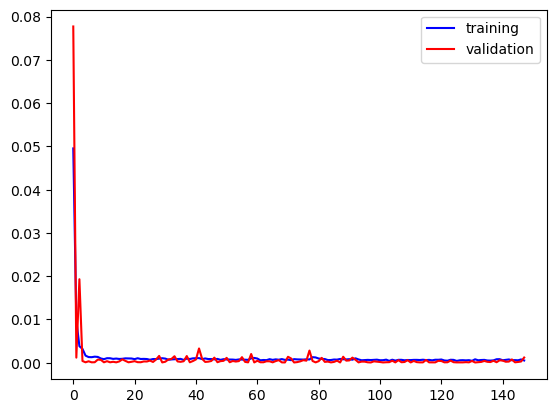

In [26]:
n_features = trainX.shape[2]

multi_model = Sequential()

# Adding the LSTM layer and dropout regularizaiton
multi_model.add(LSTM(100, return_sequences = True, input_shape=(n_steps_in, n_features)))
multi_model.add(LSTM(100))
multi_model.add(Dropout(0.2))

# Adding output layer
multi_model.add(Dense(n_steps_out))

multi_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'mean_squared_error')

earlystop = EarlyStopping(monitor = 'val_loss', patience =50,
                  mode = 'min',
                  verbose = 0)

fit = multi_model.fit(trainX,
          trainy, validation_data = (testX, testy),
          epochs = 500, verbose=0, callbacks = [earlystop])


# Check for overfitting
plt.plot(fit.history['loss'], label = 'training', color = 'Blue')
plt.plot(fit.history['val_loss'], label = 'validation', color = 'Red')
plt.legend()
plt.show()

### Feature Importance

Here, we will be using pertubation effect. The idea here involves introducing noise/perturbing each variable with a random normal distribution then caclulate the difference between the perturbed predicted y and original predicted y.

In [27]:
def feature_importance(model, g):
    random_ind = np.random.choice(g.shape[0], 100, replace=False) # Randomly generate 100 numbers arange(218)
    x = g[random_ind] #  Take 100 random sample from training set
    orig_out = model.predict(x)
    for i in range(8):  # iterate over the 7 features
        new_x = x.copy()
        perturbation_in = np.random.normal(0.0, 0.7, size=new_x.shape[:2]) # Draw random samples from normal distribution with sd = 0.7, this value is arbitary and would not affect the order of effect as its just introducing noise.
        new_x[:, :, i] = new_x[:, :, i] + perturbation_in
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5
        print(f'Variable {i+1}, Perturbation Effect: {effect:.3f}')

feature_importance(multi_model,trainX)

4/4 [==============================] - 0s 5ms/step
Variable 1, Perturbation Effect: 0.084
4/4 [==============================] - 0s 5ms/step
Variable 2, Perturbation Effect: 0.013
4/4 [==============================] - 0s 5ms/step
Variable 3, Perturbation Effect: 0.073
4/4 [==============================] - 0s 5ms/step
Variable 4, Perturbation Effect: 0.026
4/4 [==============================] - 0s 5ms/step
Variable 5, Perturbation Effect: 0.055
4/4 [==============================] - 0s 5ms/step
Variable 6, Perturbation Effect: 0.012
4/4 [==============================] - 0s 5ms/step
Variable 7, Perturbation Effect: 0.004
4/4 [==============================] - 0s 5ms/step
Variable 8, Perturbation Effect: 0.010


With the perturbation effect results, we could say that the important features for forecasting Core CPI in this model/dataset is **past Core CPI**, **Personal Consumption Expenditure**, and **M2**. Personal Consumption is one of the most important feature and this is obvious because PCE is also an important metric in determining inflation thus it should be closely correlated with Core CPI.

### Predictions on Test Dataset

After prediction, we need to invert the min-max normalization. To do so, we reshape the data back to the original form before the normalization.

- Reshape the testX and concatenate with the y-hat (prediction) at the correct positions
- Reshape the testX and concatenate with the actual y at the correct positions

To match the order of the original dataframe, we concatenate in the order of unemployment_rate, m2, pce, dspic, ffr, psr and cpi.

In [28]:
testPredict = multi_model.predict(testX)
testX = testX.reshape((testX.shape[0], testX.shape[2]*testX.shape[1]))

# Invert scaling for Predicted
testY_hat = np.concatenate((testX[:, 1:8], testPredict), axis=1)
testY_hat = scaler.inverse_transform(testY_hat)

testY_hat = testY_hat[:,7]

# Invert scaling for Actual
testY_actual = np.concatenate((testX[:,1:8], testy), axis=1)
testY_actual = scaler.inverse_transform(testY_actual)

testY_actual = testY_actual[:,7]

1/1 [==============================] - 0s 18ms/step


### Evaluating the Multivariate LSTM

We will use the metrics MSE and Mean Model Error.

In [29]:
mse = mean_squared_error(testY_actual, testY_hat)
print('Test MSE: %.3f' % mse)

model_error = testY_actual - testY_hat
print('Mean Model Error: ', model_error.mean())

Test MSE: 19.475
Mean Model Error:  4.242099933519943


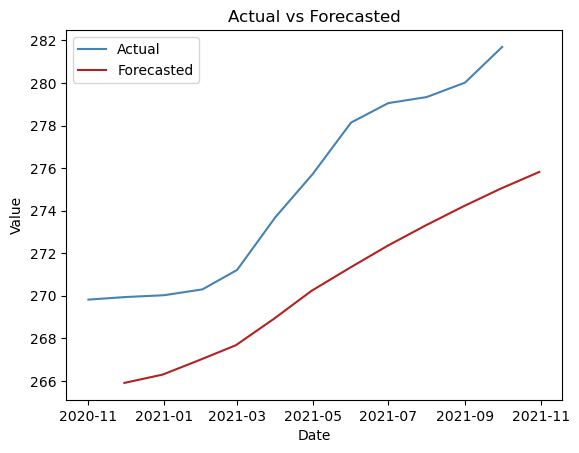

In [30]:
import matplotlib.pyplot as plt

# Plot observed data
observed = df.loc['2020-11-01':'2021-10-01', ['ccpi']]
plt.plot(observed.index, observed['ccpi'], color='SteelBlue', label='Actual')

# Plot forecasted data
predicted = pd.DataFrame(testY_hat, index=pd.date_range('2020-11-01', periods=12, freq='M'))
plt.plot(predicted.index, predicted[0], color='Firebrick', label='Forecasted')

# Add titles and labels
plt.title('Actual vs Forecasted')
plt.xlabel('Date')
plt.ylabel('Value')

# Show legend
plt.legend()

# Show the plot
plt.show()

The model had a bad start in January was unable to 'approximate' the actual shape of the Core CPI in 2020.

### Forecast for November 2021

In [31]:
x_input = np.array(scaled[-12:])
x_input = x_input.reshape((1, n_steps_in, n_features))

forecast_normalized = multi_model.predict(x_input)

# Manually inverse Min-max normalization
max_cpi = df['ccpi'].max()
min_cpi = df['ccpi'].min()
forecast =  max_cpi-forecast_normalized[0][0]/(max_cpi-min_cpi)
print('The Core CPI value for the month Nov 2021 predicted by LSTM is ', forecast)

pct_chg = ((forecast - df.iloc[-12]['ccpi'])/df.iloc[-12]['ccpi']) * 100
print('The forecasted U.S. Core Consumer Price Index (CPI) YoY is ', round(pct_chg,2))

1/1 [==============================] - 0s 19ms/step
The Core CPI value for the month Nov 2021 predicted by LSTM is  281.68939946706996
The forecasted U.S. Core Consumer Price Index (CPI) YoY is  4.4
